In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from skimpy import skim

In [13]:
from ESRNN import ESRNN
from ESRNN.m4_data import prepare_m4_data
from ESRNN.utils_evaluation import evaluate_prediction_owa
from ESRNN.utils_visualization import plot_grid_prediction

In [90]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import TCNModel, NBEATSModel
from darts.metrics import rmse, mape
from darts.utils.likelihood_models import QuantileRegression

In [5]:
X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name="Hourly", directory="data/", num_obs=414)

In [6]:
model = ESRNN(max_epochs=5, freq_of_test=1, batch_size=32, learning_rate=0.02, per_series_lr_multip=0.5, lr_scheduler_step_size=7, lr_decay=0.5,
             gradient_clipping_threshold=50, rnn_weight_decay=0.0, noise_std=0.001, level_variability_penalty=30, training_percentile=50, testing_percentile=50,
             ensemble=True, max_periods=371, seasonality=[24, 168], input_size=24, output_size=48, cell_type='LSTM', state_hsize=40, dilations=[[1, 4, 24, 168]],
             add_nl_layer=False, device='cpu')

In [8]:
model.fit(X_train_df, y_train_df)

Infered frequency: H
=============== Training ESRNN  ===============

========= Epoch 0 finished =========
Training time: 50.57801
Training loss (50 prc): 0.70241
========= Epoch 1 finished =========
Training time: 62.39236
Training loss (50 prc): 0.59290
========= Epoch 2 finished =========
Training time: 61.57894
Training loss (50 prc): 0.53480
========= Epoch 3 finished =========
Training time: 54.27468
Training loss (50 prc): 0.49682
========= Epoch 4 finished =========
Training time: 52.50252
Training loss (50 prc): 0.46950
Train finished! 



In [11]:
y_pred_df = model.predict(X_test_df)
final_owa, final_mase, final_smape = evaluate_prediction_owa(y_pred_df, y_train_df, X_test_df, y_test_df, naive2_seasonality=24)

===============  Model evaluation  ==============
OWA: 0.986 
SMAPE: 15.619 
MASE: 2.687 


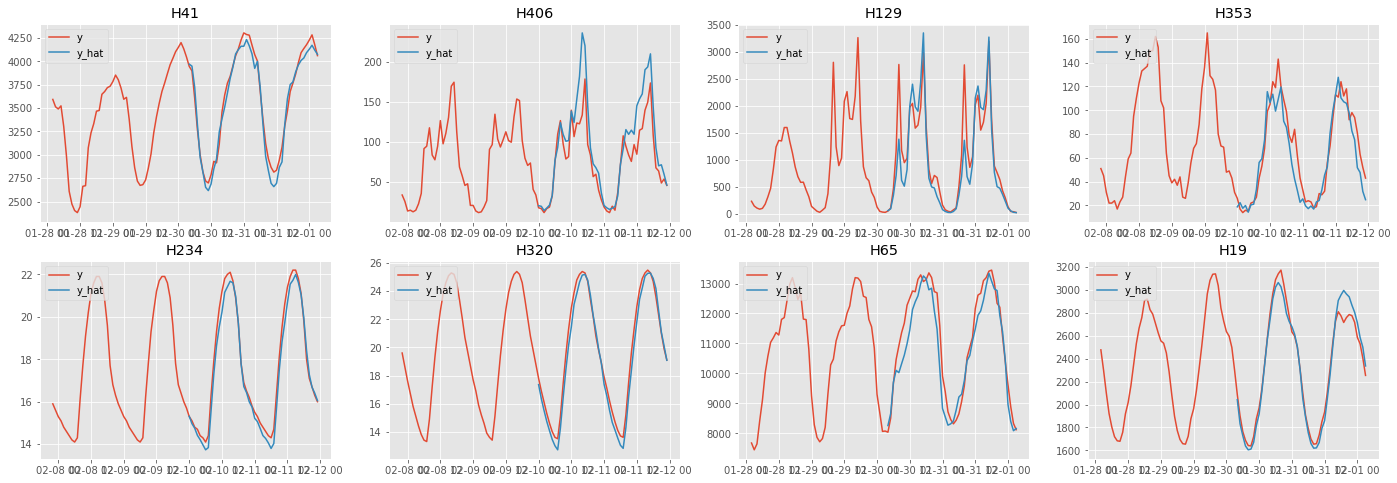

In [14]:
unique_ids = ['H129', 'H41', 'H406', 'H234', 
              'H65', 'H19', 'H320', 'H353']

plot_preds = pd.concat([y_train_df.groupby('unique_id').tail(50), y_test_df], sort=True)

plot_grid_prediction(plot_preds, y_pred_df, unique_ids=unique_ids)

In [46]:
df = pd.read_csv('data/COMED_hourly.csv', parse_dates=['Datetime']).query("Datetime > '2011-12-31'").reset_index(drop=True).set_index('Datetime').resample('D').mean()

In [48]:
df.index.duplicated().sum()

0

<AxesSubplot:xlabel='Datetime'>

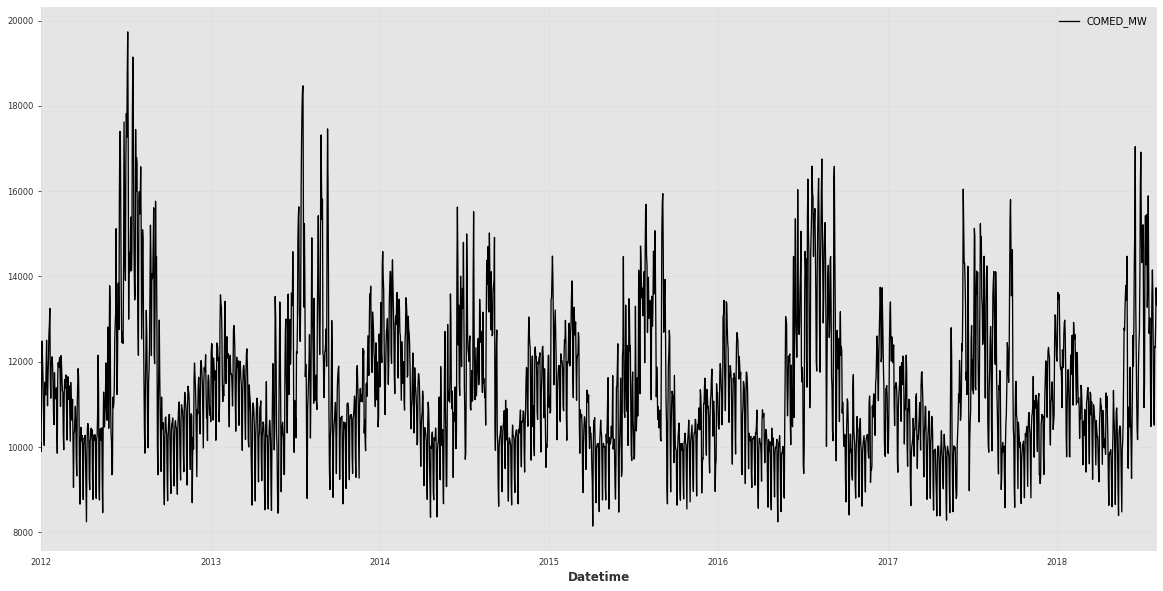

In [49]:
df.plot(figsize=(20, 10))

In [66]:
series = TimeSeries.from_dataframe(df)

In [67]:
train, val = series.split_after(pd.Timestamp('2017-09-01'))
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
series_transformed = scaler.transform(series)

In [68]:
# add the day as a covariate
day_series = datetime_attribute_timeseries(series_transformed, attribute="day", one_hot=True)

scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("2017-09-01"))

In [69]:
model = TCNModel(n_epochs=2, input_chunk_length=365, output_chunk_length=7, dropout=0.0, dilation_base=2, weight_norm=True, kernel_size=7, num_filters=4)

In [70]:
model.fit(series=train_transformed, past_covariates=train_day, verbose=True)

[2022-09-18 03:42:10,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1701 samples.
[2022-09-18 03:42:10,303] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1701 samples.
2022-09-18 03:42:10 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 1701 samples.
[2022-09-18 03:42:10,338] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-09-18 03:42:10,338] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
2022-09-18 03:42:10 darts.models.forecasting.tcn_model INFO: Number of layers chosen: 5
[2022-09-18 03:42:10,346] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-09-18 03:42:10,346] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-09-18 03:42:10 darts.models.forecasting.torch_forecasting_model INFO: Time 

Training: 0it [00:00, ?it/s]

In [ ]:
# It will take a long time ...
backtest = model.historical_forecasts(series=series_transformed, past_covariates=day_series, start=0.7, forecast_horizon=7, stride=7, retrain=True, verbose=False)

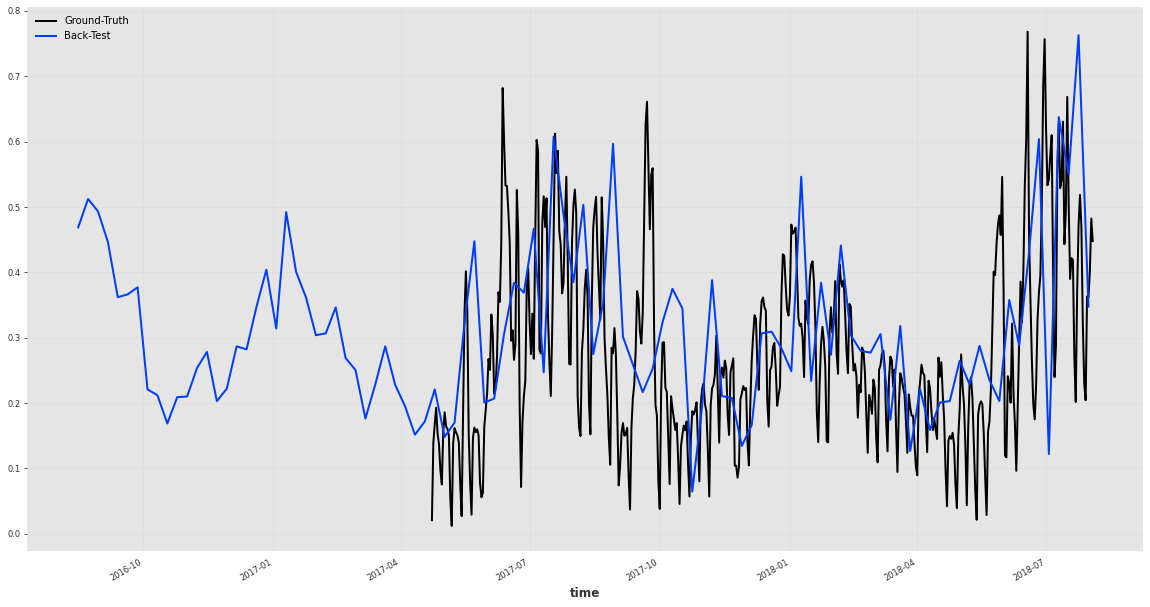

In [82]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

series_transformed[-len(backtest) - 365:].plot(label='Ground-Truth')
backtest.plot(label='Back-Test')

In [89]:
np.round(rmse(series_transformed, backtest), decimals=2)

0.13

In [92]:
# NBEATS HyperParameter


EPOCHS = 5
INLEN = 32          # input size
BLOCKS = 64         
LWIDTH = 32
BATCH = 64          # batch size
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 1            # output size
RAND = 42           # random seed
N_JOBS = -1          # parallel processors to use;  -1 = all processors


SPLIT = 0.9         # train/test split


# parameters for the probabilistic forecast
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
qL1, qL2 = 0.01, 0.10                     # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,                  # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [93]:
model = NBEATSModel(    
    input_chunk_length=INLEN,
    output_chunk_length=N_FC, 
    num_stacks=BLOCKS,
    layer_widths=LWIDTH,
    batch_size=BATCH,
    n_epochs=EPOCHS,
    nr_epochs_val_period=VALWAIT, 
    likelihood=QuantileRegression(QUANTILES), 
    optimizer_kwargs={"lr": LEARN}, 
    model_name="NBEATS_EnergyES",
    log_tensorboard=True,
    generic_architecture=True, 
    random_state=RAND,
    force_reset=True,
    save_checkpoints=True
)

In [ ]:
# It takes forever ...
backtest = model.historical_forecasts(
    series=series_transformed,
    past_covariates=day_series,
    start=0.7,
    forecast_horizon=7,
    stride=7,
    retrain=True, verbose=False)

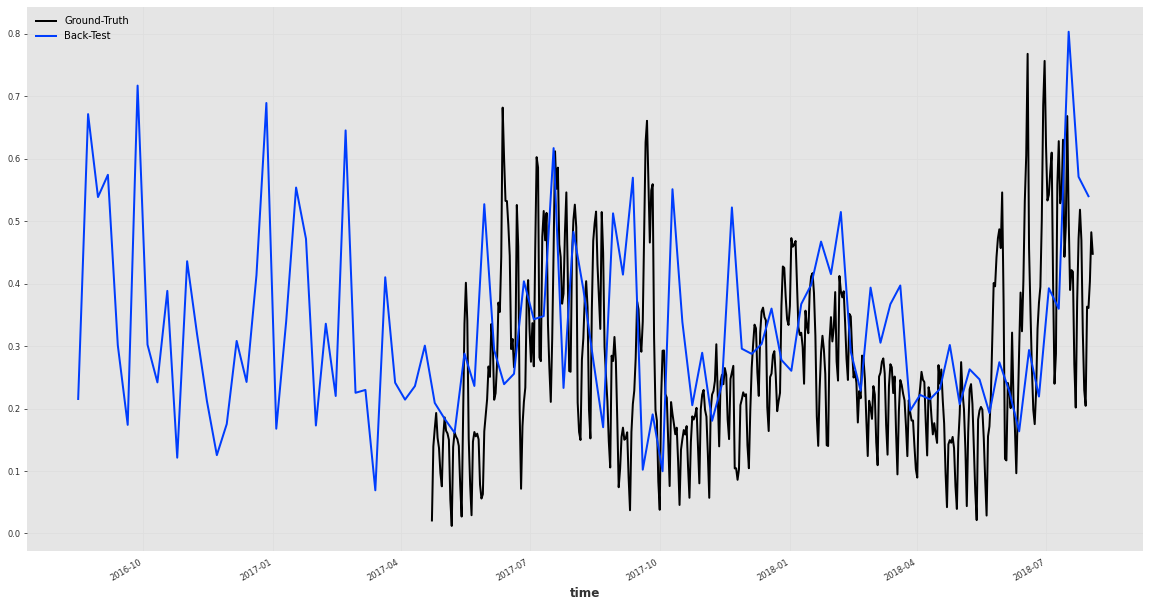

In [96]:
fig = plt.gcf()
fig.set_size_inches(20, 10)

series_transformed[-len(backtest) - 365:].plot(label='Ground-Truth')
backtest.plot(label='Back-Test')

In [97]:
np.round(rmse(series_transformed, backtest), decimals=2)

0.18